# MATH50003 Numerical Analysis (2023–2024) Computer-based Exam

Instructions for uploading and downloading:

1. Rename the file to include your CID.
2. You have 15 mins to download the exam beginning at 9:00 on 15 March. **DO NOT** write or type anything during this time.
2. You have 1 hour to complete the exam beginning at 9:15 on 15 March. You **MUST STOP** typing at 10:15.
3. Deadline is 10:30 on 15 March to upload the completed Jupyter notebook (`.ipynb`) to Blackboard.
5. Once uploaded, re-download the file before the final submission time to confirm it is correct.
You are allowed to upload additional submissions but only the last valid upload before 10:30 will be used.
6. If uploading via Blackboard fails or please contact an invigilator.

Instructions for the exam:

1. For each problem, replace the `# TODO` to complete the question.
The unit tests are provided to help you test your answers, but do not guarantee that the answer is correct.
2. Problems are marked A/B/C to indicate difficulty ("A" being most difficult).
3. All questions are worth 10 marks. Partial credit will be awarded for reasonable attempts or comments outlining a solution even if the tests
are not passed.
3. If you have technical queries please contact an invigilator.
4. You may use existing code from anywhere
but you are **REQUIRED** to cite the source if it is not part of the module material,
by including a weblink in a comment.
5. You **MUST NOT** ask for help online or
communicate with others within or outside the module.
Failure to follow these rules will be considered misconduct.
6. **NO USAGE of AI tools** such as ChatGPT or GitHub Co-Pilot.
7. **TURN OFF notifications** on your machine. In particular, close background processes for any chat applications (iMessage, WhatsApp, WeChat).

You should use the following packages:

In [1]:
using LinearAlgebra, SetRounding, Test, Plots

**WARNING** It may be necessary to restart the kernel if issues arise. Remember to reload the packages
when you do so.

-----

**Problem 1 (C)** Implement the mid-point rule for approximating an integral:
$$
\int_0^1 f(x) {\rm d}x ≈ {1 \over n} \sum_{k=1}^n f(x_{k-1/2})
$$
where $x_k := k/n$. By computing with various values of $n$, conjecture what the convergence rate is as $n → ∞$,
that is, for what $λ$ is the error $O(n^{-λ})$? You may assume all numbers are `Float64`.

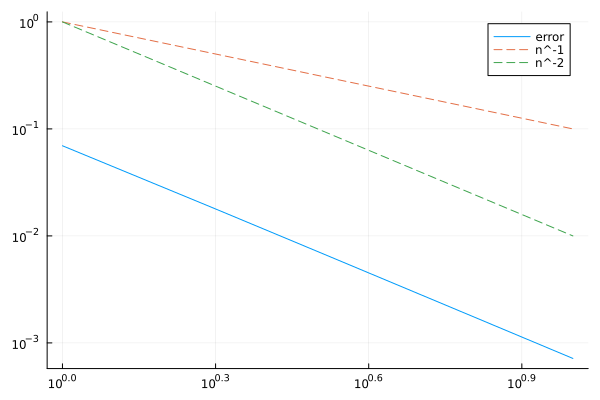

In [9]:
function midpointrule(f, n)
    # TODO: implement the mid-point rule
    h = 1 / n
    ret = 0
    for i in 1:n
        ret += f((i - 1/2) / n)
    end
    ret / n
end

@test midpointrule(exp, 5000) ≈ (exp(1)-1)

# TODO: Replace 0 below to set λ to what you conjecture that the convergence rate O(n^(-λ)) is.
# Include any experiments/comments to justify your conjecture.
λ = 2
N = 1e1
nanabs = x -> (x == 0 ? NaN : abs(x))
plot(1:N, nanabs.(midpointrule.(exp, 1:N) .- (exp(1)-1)); xscale=:log10, yscale=:log10, label="error", yticks=10.0 .^ (-10:1)) # yticks specifies the ticks used on the y-axis
plot!(1:N, (1:N) .^ (-1); linestyle=:dash, label="n^-1") # exclamation point means add to existing plot
plot!(1:N, (1:N) .^ (-2); linestyle=:dash, label="n^-2")

**Problem 2 (B)** Derive a third-order divided difference formula by combining a first-order and second-order divided difference, that
evaluates at the points $f(x+2h), f(x+h), f(x),$ and $f(x-h)$.
Implement this formula in the following function:

In [10]:
function thirdorderdivideddifference(f, x, h)
    # TODO: approximate f'''(x) by deriving a third-order divided difference formula
    (f(x + 2h) - 3f(x + h) + 3f(x) - f(x - h)) / h^3
end

# We test with BigFloat as the round-off errors in third-order divided differences are too large to get accurate digits:
@test thirdorderdivideddifference(x -> cos(x^2), big(1.0), big(0.0000001)) ≈ -12cos(1) + 8sin(1) atol=1E-5

Test Passed

**Problem 3 (C)** Add support for `tan` and `acos` (which implements $\arccos(x)$)  with duals. You may use the provided `cos` and `sin`
implementations. Hint: recall that $\arccos'(x) = -1/\sqrt{1-x^2}$.

In [11]:
struct Dual
    a
    b
end

import Base: tan, acos, cos, sin, /


cos(x::Dual) = Dual(cos(x.a), -sin(x.a) * x.b)
sin(x::Dual) = Dual(sin(x.a), cos(x.a) * x.b)
function /(x::Dual, y::Dual)
    if iszero(y.a)
        error("Division for dual numbers is ill-defined when denonimator real part is zero.")
    end
    return Dual(x.a / y.a, (y.a * x.b - x.a * y.b) / y.a^2)
end

function tan(x::Dual)
    # TODO: implement tan for dual numbers
    Dual(tan(x.a), x.b / cos(x.a)^2)
end

function acos(x::Dual)
    # TODO: implement acos, i.e. arccos, for dual numbers
    Dual(acos(x.a), x.b * (-1 / sqrt(1 - x.a^2)))
end

@test (tan(acos(Dual(0.1,1)))/cos(Dual(0.1,1))).a ≈ tan(acos(0.1))/cos(0.1)
@test (tan(acos(Dual(0.1,1)))/cos(Dual(0.1,1))).b ≈ -((sec(0.1)*(1 + 0.1*(0.1^2-1)*tan(0.1)))/(0.1^2*sqrt(1 - 0.1^2)))

Test Passed

**Problem 4 (C)** A `Float16` represents a number of the form $2^{q-15} (1.b_1…b_{10})_2$.
 Create a function that returns the exponent $q$ of a `Float16` as an `UInt8`. Do not use the
built-in `exponent` function. Hint: combine `bitstring` and `parse`.

In [17]:
function floatexponent(x::Float16)
    # TODO: return the exponent of x
    s = bitstring(x)
    parse(UInt8, s[2:6]; base=2)
end


@test floatexponent(Float16(0.0123)) isa UInt8
@test floatexponent(Float16(0.0123)) == 8

Test Passed

**Problem 5.1 (C)** Complete the implementation of a function `cos_t(x,n)` computing the
first `2n` terms of the Taylor series:
$$
\cos\ x ≈ ∑_{k=0}^n {(-1)^k x^{2k} \over (2k)!}
$$

In [18]:
function cos_t(x, n)
    ret = 1
    s = 1
    # TODO: Compute the first 2n terms of the Taylor series of cos,
    # without using the factorial function.
    for k in 1:n
        s *= -x^2 / (2k - 1) / (2k)
        ret += s
    end
    ret
end

@test cos_t(1.0, 10) ≈ cos(1)

Test Passed

**Problem 5.2 (B)**  Complete the implementation of a function `cos_bound(x,n)` that
includes an error bound on the computation. You may assume $0 ≤ x ≤ 1$.

In [30]:
struct Interval # represents the set [a,b]
    a # left endpoint
    b # right endpoint
end

Interval(x) = Interval(x,x) # Support Interval(1) to represent [1,1]

import Base: *, +, -, ^, /, one, in

in(x, X::Interval) = X.a ≤ x ≤ X.b
one(X::Interval) = Interval(one(X.a), one(X.b))
function +(X::Interval, Y::Interval)
    a,b,c,d = promote(X.a, X.b, Y.a, Y.b) # make sure all are the same type
    T = typeof(a)
    α = setrounding(T, RoundDown) do
        a + c
    end
    β = setrounding(T, RoundUp) do
        b + d
    end
    Interval(α, β)
end
function -(X::Interval)
    a,b = promote(X.a, X.b)
    Interval(-b, -a)
end
function /(X::Interval, n::Int)
    a,b = promote(X.a, X.b)
    T = eltype(a)
    if n == 0
        error("Dividing by zero not support")
    end
    α = setrounding(T, RoundDown) do
        n > 0 ? a / n : b / n
    end
    β = setrounding(T, RoundUp) do
        n > 0 ? b / n : a / n
    end
    Interval(α, β)
end
function *(X::Interval, Y::Interval)
    a,b,c,d = promote(X.a, X.b, Y.a, Y.b)
    T = typeof(a)
    if !(a ≤ b && c ≤ d)
        error("Empty intervals not supported.")
    end
    α = setrounding(T, RoundDown) do
        min(a*c,a*d,b*c,b*d)
    end
    β = setrounding(T, RoundUp) do
        max(a*c,a*d,b*c,b*d)
    end
    Interval(α, β)
end
function ^(X::Interval, k::Int)
    if k ≤ 0
        error("not supported")
    elseif k == 1
        X
    else
        X * X^(k-1)
    end
end


function cos_bound(X::Interval, n)
    a,b = promote(X.a, X.b)
    T = typeof(a)
    if !(0 ≤ a ≤ b ≤ 1)
        error("Interval must be a subset of [0, 1]")
    end
    # TODO: complete the implementation of cosine applied to an interval,
    # including the error in truncating the Taylor series.
    ret = Interval(1)
    s = Interval(1)
    for k in 1:n
        s *= X^2 / (2k - 1) / (2k) * Interval(-1)
        ret = ret + s
    end
    
    err = 1
    for i in 2:2n+2
        err /= i
    end
    ret + Interval(-err, err)
end

@test cos(big(1)) in cos_bound(Interval(1.0), 10)
@test cos_bound(Interval(1.0), 10).b - cos_bound(Interval(1.0), 10).a ≤ 1E-14

Test Passed

**Problem 6 (B)** Complete the implementation of `LowerTridiagonal` which represents an $n × n$ banded matrix with
bandwidths $(l,u) = (2,0)$ by storing only its diagonal, sub-diagonal, and second-sub-diagonal as vectors.
Overload `setindex!`, as well as `\` to solve a lower tridiagonal system in $O(n)$ operations. For simplicity you may assume all numbers are `Float64`.

In [32]:
import Base: getindex, setindex!, size, \

struct LowerTridiagonal <: AbstractMatrix{Float64}
    d::Vector{Float64}   # diagonal entries of length n
    dl::Vector{Float64}  # sub-diagonal entries of length n-1
    dl2::Vector{Float64} # second-sub-diagonal entries of length n-2
end

size(L::LowerTridiagonal) = (length(L.d),length(L.d))

# implements L[k,j]
function getindex(L::LowerTridiagonal, k::Int, j::Int)
    d, dl, dl2 = L.d, L.dl, L.dl2
    if k == j
        d[k]
    elseif k == j+1
        dl[j]
    elseif k == j+2
        dl2[j]
    else
        0.0
    end
end

# implements L[k,j] = v
function setindex!(L::LowerTridiagonal, v, k::Int, j::Int)
    d, dl, dl2 = L.d, L.dl, L.dl2
    if j > k || j < k-2
        error("Cannot modify off-band")
    end
    # TODO: set L[k,j] to be equal to v
    if k == j
        d[k] = v
    elseif k == j+1
        dl[j] = v
    elseif k == j+2
        dl2[j] = v
    end
    
end

function \(L::LowerTridiagonal, b::AbstractVector)
    m,n = size(L) # we know m == n
    if n ≠ length(b)
        error("Dimensions do not match")
    end
    if n < 1
        error("Empty vectors not supported")
    end
    x = zeros(n) # Vector to be populated
    # TODO: Populate the vector x so that L*x ≈ b, using O(n) operations.
    x[1] = b[1] / L[1, 1]
    x[2] = (b[2] - x[1] * L[2, 1]) / L[2, 2]
    for i in 3:n
        x[i] = (b[i] - x[i - 2] * L[i, i - 2] - x[i - 1] * L[i, i - 1]) / L[i, i]
    end
    x
end

n = 10
d, dl, dl2 = randn(n), randn(n-1), randn(n-2)
L = LowerTridiagonal(d, dl, dl2)
@test L == diagm(0 => d, -1 => dl, -2 => dl2)

L[3,2] = 4
@test L[3,2] == 4

b = randn(n)
@test L\b ≈ Matrix(L)\b

Test Passed

**Problem 7 (A)**  Consider the second-order initial value problem
$$
u(0) = 1, u'(0) = 0, u''(x) = x u(x)
$$
for $x ∈ [0,1]$. Recast this problem as a linear system involving a `LowerTridiagonal` matrix (as defined in Problem 6)
using a finite-difference approximation on the evenly grid $x_0,x_1,…,x_n$
where $x_k = k/n$ using the right-sided divided difference to approximate
$$
u'(0) ≈ {u(h) - u(0) \over h}
$$
and the second-order divided difference approximation
$$
u''(x) ≈ {u(x+h) - 2u(x) + u(x-h) \over h^2}
$$
imposed at the grid points $x_1,…,x_{n-1}$.

In [43]:
function secondorderairysystem(n)
    # TODO: return a LowerTridiagonal matrix representing the differential operator u'' - x*u,
    # with the first two rows representing the initial conditions u(0) and u'(0)
    x = range(0, 1; length = n + 1)
    h = 1 / n
    
    LowerTridiagonal([1; 1/h; fill(1/h^2, n-1)],
                    [-1/h; fill(-2/h^2, n-1) - x[2:n]],
                    fill(1/h^2, n-1))
end

function secondorderairyrhs(n)
    # TODO: return the right-hand side corresponding to the above system.
    [1; fill(0, n)]
end

n = 1000
@test secondorderairysystem(n) isa LowerTridiagonal
u = secondorderairysystem(n) \ secondorderairyrhs(n)
print(u[end-5:end])
@test u[end] ≈ 1.1722999700579313 atol=1E-5

[1.169644219979078, 1.1701729964927454, 1.1707029384987173, 1.171234047695519, 1.1717663257839, 1.1722997744668406]

Test Passed

**Problem 8.1 (B)** Implement the following function that given a real vector $𝐱$ will return a 2 × 2 rotation matrix such that
$$
Q 𝐱 = \| 𝐱 \| 𝐞_2.
$$
You may assume all numbers are `Float64`.

In [50]:
function rotatedown(x)
    if length(x) ≠ 2
        error("Length must be 2")
    end
    # TODO: Create a 2 × 2 rotation matrix Q such that Q*x = [0,norm(x)].
    angle = atan(x[1], x[2])
    [cos(angle) (-sin(angle));
     sin(angle) cos(angle)]

end

x = randn(2)
Q = rotatedown(x)
@test Q'Q ≈ I
@test det(Q) ≈ 1
@test Q*x ≈ [0,norm(x)]

Test Passed

**Problem 8.2 (A)** Implement a QL factorisation for a tridiagonal matrix, returning an orthogonal matrix `Q`
and `L`  represented as a `LowerTridiagonal` matrix, as defined in Problem 6. You may assume all numbers are `Float64`. Hint: unlike the `bandedqr` implemented in the labs, `Q` may be stored as
as a dense matrix. Because of this your solution will likely take $O(n^2)$ operations.

In [ ]:
function bandedql(A::Tridiagonal)
    n = size(A, 1)
    Q = Matrix(1.0I, n, n) # create an n × n identity matrix
    L = LowerTridiagonal(zeros(n), zeros(n - 1), zeros(n - 2))

    # TODO: Populate Q and L so that Q*L ≈ A in at most O(n^2) operations.

    # TODO: Populate Q and R by looping through the columns of A.

    # SOLUTION
    # In what follows we use both A and R simultaneously, where R
    # represents the upper-triangular part of the modified A, up to rows j.
    # At each stage we apply the rotation Q_j that introduces a zero
    # in the (j+1,j) entry of A.

    # To begin with we haven't applied Q so R contains just the first row of A.

    L[1:2, 1] = A[1:2, 1]

    for j = 1:n-1
        # We determine the angle of rotation. Note R contains the updated entries
        # on or above the diagonal whilst A containss the unmodified entries below the diagonal.
        x_1 = [R[j, j], A[j+1, j]]
        Q.θ[j] = atan(x_1[2], x_1[1])
        Q_1 = Rotation(-Q.θ[j]) # rotate in opposite direction
        # Q satisfies Q*[ R[j,j],A[j+1,j]] = [sqrt(R[j,j]^2+A[j+1,j]^2), 0]
        # Or we can just write this as:
        R[j, j] = (Q_1 * x_1)[1]

        # We now apply this to the rest of the columns to update R.
        x_2 = [R[j, j+1]; A[j+1, j+1]]
        R[j:j+1, j+1] = Q_1 * x_2

        if j < n - 1 # need to avoid going beyond the dimension
            # We use the fact that A is banded so there is a 0.
            x_3 = [0, A[j+1, j+2]]
            R[j:j+1, j+2] = Q_1 * x_3
        end
    end
    # END

    Q, L
end

n = 100
A = Tridiagonal(randn(n-1), randn(n), randn(n-1))
Q,L = bandedql(A)

@test Q'*Q ≈ I
@test L isa LowerTridiagonal
@test Q*L ≈ A

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*